In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

/opt/anaconda3/envs/python37/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [7]:
df = pd.read_csv('titles_yahoo_financial_616.csv')
df.head()

,News Titles
0,Bitcoin Spot ETFs Register Five-Day Withdrawal...
1,Why Altcoins Were Sliding Again Today
2,The tweak that made the forced divestment of T...
3,Procter & Gamble Tops Wall Street Forecasts on...
4,Stock market today: Indexes edge lower as inve...


In [8]:
# Convert to list
data = df['News Titles'].values.tolist()

# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Bitcoin Spot ETFs Register Five-Day Withdrawals Streak Ahead of Halving']


In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['bitcoin', 'spot', 'etfs', 'register', 'five', 'day', 'withdrawals', 'streak', 'ahead', 'of', 'halving']]


In [16]:
import warnings

# Suppress specific deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module='catalogue')

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['day withdrawal streak ahead halve', 'why altcoin slide again today']


In [19]:
#convert text into word matrix
from sklearn.feature_extraction.text import CountVectorizer
#max_df=0.95-> gets rid of terms appears in over 95% documents (not much informational value if it appears in a lot of document)
#min_df=2 -> minimum frequency for a word to be counted into this CountVectorizer it has to show up in at least two documents
#to save time, I am not writing a preprocessing function but just ask sklearn to remove stopwords, but you could still do preprocessing if you wish.
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
#transform the data to create a document term matrix, where each row is a list of words with frequency (bag or words)
data_vectorized = cv.fit_transform(data_lemmatized)

In [20]:
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.8558514656075631 %


In [44]:
search_params = {'n_components': list(range(3,20)), 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                          14, 15, 16, 17, 18, 19]})

In [45]:
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 3}
Best Log Likelihood Score:  -4459.848788580687
Model Perplexity:  447.7244717583295


In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

results = model.cv_results_
scores = results['mean_test_score']
params = results['params']

n_components = [param['n_components'] for param in params]
learning_decays = [param['learning_decay'] for param in params]

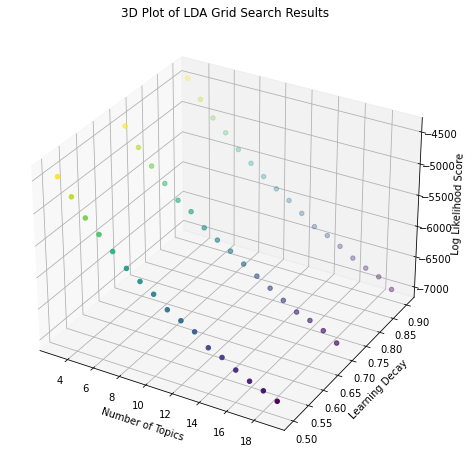

In [47]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Data points
ax.scatter(n_components, learning_decays, scores, c=scores, cmap='viridis', marker='o')

# Labels and title
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Learning Decay')
ax.set_zlabel('Log Likelihood Score')
ax.set_title('3D Plot of LDA Grid Search Results')

# Show plot
plt.show()

In [61]:
lda_output = best_lda_model.fit_transform(data_vectorized)

print(best_lda_model)  # Model attributes

LatentDirichletAllocation(learning_decay=0.9, n_components=3)


In [62]:
for index,topic in enumerate(best_lda_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['global', 'week', 'buy', 'sell', 'risk', 'report', 'halving', 'crypto', 'say', 'halve', 'price', 'oil', 'stock', 'bitcoin', 'market']


THE TOP 15 WORDS FOR TOPIC #1
['good', 'sale', 'segment', 'low', 'semiconductor', 'look', 'inflation', 'week', 'market', 'analyst', 'accord', 'buy', 'rest', 'earning', 'stock']


THE TOP 15 WORDS FOR TOPIC #2
['hold', 'medium', 'fed', 'high', 'trump', 'mortgage', 'new', 'inflation', 'market', 'year', 'today', 'cut', 'stock', 'say', 'rate']




In [56]:
lda_output.shape

(616, 3)

In [57]:
df['Topic'] = lda_output.argmax(axis=1)
df.head()

,News Titles,Topic
0,Bitcoin Spot ETFs Register Five-Day Withdrawal...,1
1,Why Altcoins Were Sliding Again Today,1
2,The tweak that made the forced divestment of T...,0
3,Procter & Gamble Tops Wall Street Forecasts on...,2
4,Stock market today: Indexes edge lower as inve...,0


In [58]:
df['Topic'].value_counts()

1    232
2    205
0    179
Name: Topic, dtype: int64

In [59]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, cv, mds='tsne')
panel

/opt/anaconda3/envs/python37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/python37/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/opt/anaconda3/envs/python37/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/python37/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
1     -1015.700562  1338.981201       1        1  36.908529
2      -387.996002  -373.316162       2        1  34.469791
0     -2184.745605   -60.565800       3        1  28.621681, topic_info=        Term        Freq       Total Category  logprob  loglift
447    stock  151.000000  151.000000  Default  30.0000  30.0000
399      say   46.000000   46.000000  Default  29.0000  29.0000
130  earning   73.000000   73.000000  Default  28.0000  28.0000
361     rate   58.000000   58.000000  Default  27.0000  27.0000
36   bitcoin   30.000000   30.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
153   expect    6.312039   14.284480   Topic3  -4.8577   0.4343
377     rest    8.003910   30.397451   Topic3  -4.6203  -0.0834
286   market    7.150726   58.972394   Topic3  -4.7330  -0.8588
464    surge    4.750248    7.568360   Topic3  -5.1420   0.7852
313      oil    5.203276   26.939055   Topic3  -5.0509  -0.3933

[172 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.940904   accord
1         3  0.950402  account
7         2  0.677026       ai
7         3  0.338513       ai
8         3  0.950374  altcoin
...     ...       ...      ...
520       3  0.950385      win
525       1  0.926762    world
531       1  0.724760     year
531       2  0.051769     year
531       3  0.207074     year

[178 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [63]:
df['Topic_Name'] = df['Topic'].apply(lambda x: 'Venture Investment' if x == 0 else ('Technology' if x == 1 else 'Financial Assets'))

In [65]:
df.to_csv('topic.csv',index=False)